# YaRN

- Blog [【手撕 YaRN】LLM 训短推长，一直外推一直爽！OpenAI / DeepSeek / Qwen 严选位置编码](https://zhuanlan.zhihu.com/p/1944715652926538312)
- 参考代码： [GPT-OSS](https://github.com/openai/gpt-oss)

In [72]:
import torch
import torch.nn
import torch.nn.functional as F
from dataclasses import dataclass
import math

## RoPE

In [192]:
def _apply_rotary_emb(
    x: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor,
) -> torch.Tensor:
    seq_len, _, _ = x.size()
    cos = cos[:seq_len,:]
    sin = sin[:seq_len,:]

    cos = cos.unsqueeze(-2).to(x.dtype)
    sin = sin.unsqueeze(-2).to(x.dtype)

    x1, x2 = torch.chunk(x, 2, dim=-1)
    o1 = x1 * cos - x2 * sin
    o2 = x2 * cos + x1 * sin
    return torch.cat((o1, o2), dim=-1)

In [193]:
class RoPE(torch.nn.Module):
    def __init__(
        self,
        head_dim: int,
        base: int,
        num_tokens: int,
    ) -> None:
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        # 创建 RoPE 对象即算好 角度值
        self.cos, self.sin = self._compute_cos_sin(num_tokens)

    def _compute_concentration_and_inv_freq(self) -> torch.Tensor:
        freq = self.base ** (torch.arange(0, self.head_dim, 2,)/ self.head_dim)
        inv_freq = 1.0 / freq
        return inv_freq

    def _compute_cos_sin(self, num_tokens: int):
        inv_freq = self._compute_concentration_and_inv_freq()
        t = torch.arange(num_tokens)
        freqs = torch.einsum("i,j->ij", t, inv_freq)
        cos = freqs.cos() 
        sin = freqs.sin() 
        return cos, sin

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        num_tokens = query.shape[0]
            
        query_shape = query.shape
        query = query.view(num_tokens, -1, self.head_dim)
        query = _apply_rotary_emb(query, self.cos, self.sin)
        query = query.reshape(query_shape)

        key_shape = key.shape
        key = key.view(num_tokens, -1, self.head_dim)
        key = _apply_rotary_emb(key, self.cos, self.sin)
        key = key.reshape(key_shape)
        return query, key

In [194]:
head_dim = 64
base = 10000.0
batch_size = 8
seq_len = 32

Q = torch.randn(seq_len, head_dim)
K = torch.randn(seq_len, head_dim)

In [195]:
rope = RoPE(head_dim, base, num_tokens = 1024)

In [196]:
rope.forward(Q, K)

(tensor([[-0.7825, -0.1707, -1.5435,  ..., -0.1420,  0.1450,  2.8950],
         [-1.4554,  0.7850, -1.1352,  ..., -1.6330,  1.2805,  0.3437],
         [ 0.6645,  0.7659,  2.0463,  ..., -0.0370, -0.2466, -1.0221],
         ...,
         [-0.4770, -0.2680, -0.2169,  ..., -0.5438,  1.1523,  0.2070],
         [ 0.2788,  0.5632,  0.2732,  ...,  0.1312, -2.8673, -0.6830],
         [-1.2732, -0.7246, -1.5800,  ...,  0.0082,  1.4999,  0.1755]]),
 tensor([[-1.6043,  0.2032,  0.2442,  ...,  0.6022, -1.4143,  1.9621],
         [ 1.6904, -1.5337,  0.6644,  ...,  0.9029, -0.0285,  0.0955],
         [ 1.9882,  0.4796,  0.3904,  ...,  0.6279,  1.2099, -1.0650],
         ...,
         [-1.8615,  0.1390, -0.0799,  ...,  1.1533, -1.1049, -0.0208],
         [ 1.4627,  0.5326, -0.0066,  ..., -0.2315, -0.2504, -0.5257],
         [ 0.5356,  0.4462,  1.2327,  ...,  0.8747,  0.6942, -1.7327]]))

## YaRN

In [238]:
class YaRN(torch.nn.Module):
    def __init__(
        self,
        head_dim: int,
        base: int,
        dtype: torch.dtype,
        initial_context_length: int = 4096,
        scaling_factor: float = 1.0,
        ntk_alpha: float = 1.0,
        ntk_beta: float = 32.0,
        device: torch.device | None = None,
    ) -> None:
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        self.dtype = dtype
        self.initial_context_length = initial_context_length
        self.scaling_factor = scaling_factor
        self.ntk_alpha = ntk_alpha
        self.ntk_beta = ntk_beta
        self.device = device

    def _compute_concentration_and_inv_freq(self) -> torch.Tensor:
        """See YaRN paper: https://arxiv.org/abs/2309.00071"""
        freq = self.base ** (
            torch.arange(0, self.head_dim, 2, dtype=torch.float, device=self.device)
            / self.head_dim
        )
        
        self.scaling_factor = max( 1, self.cur_context_length  / self.initial_context_length)

        # if self.cur_context_length > self.initial_context_length:
        #     self.initial_context_length = self.cur_context_length
        
        if self.scaling_factor > 1.0:
            
            # 3️⃣ YaRN:  Re-Scale
            # concentration: \sqrt{1/t} = 0.1 log(s) + 1.0
            # t = 1/(0.1log(s)+1.0)^2
            concentration = (
                0.1 * math.log(self.scaling_factor) + 1.0
            )  # YaRN concentration
            print('t:',  1/concentration**2)

            d_half = self.head_dim / 2

            # 1️⃣ YaRN:  NTK by parts
            low = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_beta * 2 * math.pi))
                / math.log(self.base)
            )
            high = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_alpha * 2 * math.pi))
                / math.log(self.base)
            )
            assert 0 < low < high < d_half - 1
            print('low, high:', low, high)

            interpolation = 1.0 / (self.scaling_factor * freq)
            extrapolation = 1.0 / freq

            ramp = (
                torch.arange(d_half, dtype=torch.float32, device=freq.device) - low
            ) / (high - low)
            mask = 1 - ramp.clamp(0, 1)

            inv_freq = interpolation * (1 - mask) + extrapolation * mask
        else:
            concentration = 1.0
            inv_freq = 1.0 / freq

        return concentration, inv_freq

    def _compute_cos_sin(self, num_tokens: int):
        concentration, inv_freq = self._compute_concentration_and_inv_freq()
        print('YaRN Re-Scale:',  concentration)
        t = torch.arange(num_tokens, dtype=torch.float32, device=self.device)
        freqs = torch.einsum("i,j->ij", t, inv_freq)
        cos = freqs.cos() * concentration
        sin = freqs.sin() * concentration
        return cos, sin

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # 2️⃣ YaRN Dynamic-Scaling 技术
        num_tokens = query.shape[0]
        self.cur_context_length = num_tokens
        cos, sin = self._compute_cos_sin(num_tokens) # 随 seq_len 增长而增长

        query_shape = query.shape
        query = query.view(num_tokens, -1, self.head_dim)
        query = _apply_rotary_emb(query, cos, sin)
        query = query.reshape(query_shape)

        key_shape = key.shape
        key = key.view(num_tokens, -1, self.head_dim)
        key = _apply_rotary_emb(key, cos, sin)
        key = key.reshape(key_shape)
        return query, key

In [239]:
yarn = YaRN(head_dim = head_dim, 
            base = 100000.0, 
            dtype=torch.float32, 
            scaling_factor=10, 
            initial_context_length=4096)

In [240]:
q_rope, k_rope = yarn.forward(Q, K)

t: 0.41381729016073177
low, high: 8.37779264825442 18.01075250950182
YaRN Re-Scale: 1.5545177444479563


In [241]:
L = 1024
for i in range(10):
    L *= 2
    print(L)
    Q = torch.randn(L, head_dim)
    K = torch.randn(L, head_dim)
    q_rope, k_rope = yarn.forward(Q, K)
    print('-'*100)

2048
YaRN Re-Scale: 1.0
----------------------------------------------------------------------------------------------------
4096
YaRN Re-Scale: 1.0
----------------------------------------------------------------------------------------------------
8192
t: 0.8745585923764103
low, high: 8.37779264825442 18.01075250950182
YaRN Re-Scale: 1.0693147180559945
----------------------------------------------------------------------------------------------------
16384
t: 0.7713210535693215
low, high: 8.37779264825442 18.01075250950182
YaRN Re-Scale: 1.138629436111989
----------------------------------------------------------------------------------------------------
32768
t: 0.6853403266295983
low, high: 8.37779264825442 18.01075250950182
YaRN Re-Scale: 1.2079441541679836
----------------------------------------------------------------------------------------------------
65536
t: 0.6129741270046833
low, high: 8.37779264825442 18.01075250950182
YaRN Re-Scale: 1.2772588722239782
-----------------

## NTK-RoPE 分析

### position encoding sin

In [166]:
x = torch.arange(0, 10)
x
x.shape

torch.Size([10])

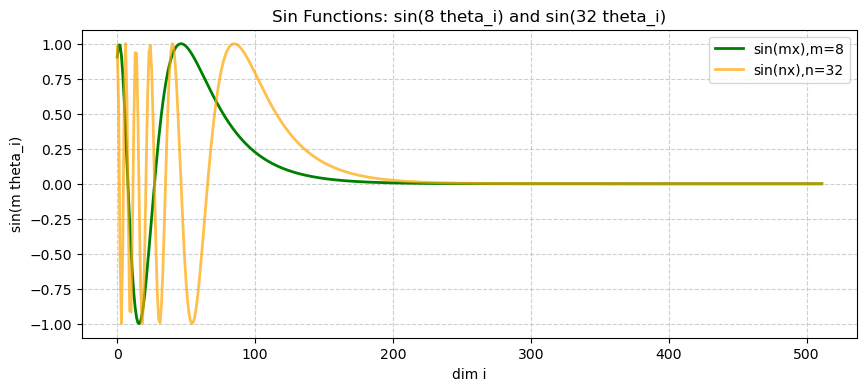

In [167]:
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 512
m = 8
n = 32
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
angle = base ** (- 2 * (x - 1) / d)


# 计算正弦值
y1 = torch.sin(m * angle)
y2 = torch.sin(n * angle)

# 创建图形
plt.figure(figsize=(10, 4))

# 绘制两条曲线
plt.plot(x.tolist(), y1.tolist(), label='sin(mx),m=8', color='green', linewidth=2)
plt.plot(x.tolist(), y2.tolist(), label='sin(nx),n=32', color='orange', linewidth=2, alpha=0.7)

# 添加标题和标签
plt.title('Sin Functions: sin(8 theta_i) and sin(32 theta_i)')
plt.xlabel('dim i')
plt.ylabel('sin(m theta_i)')

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/m_curve.svg')
plt.show()

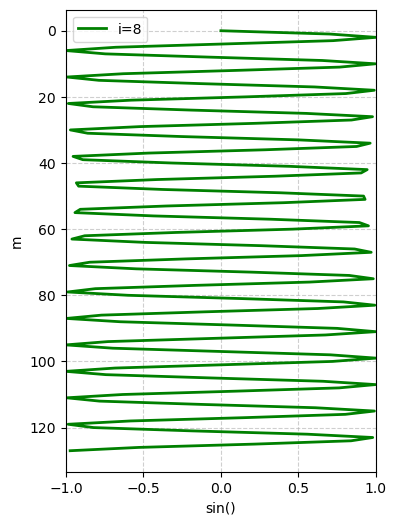

In [168]:
# theta curve

## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 512
m = 128
# n = 32
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
angle = base ** ( - 2 * (x - 1) / d)

a1 = angle[8]
a32 = angle[128]

pos_ids = torch.arange(0, m)
# print(pos_ids)


# 计算正弦值
y1 = torch.sin(pos_ids * a1)
y2 = torch.sin(pos_ids * a32)

a1_ids = torch.ones(1, m) * a1
a32_ids = torch.ones(1, m) * a32
a1_ids = a1_ids[0,:]
a32_ids = a32_ids[0,:]
# print(a1_ids.shape)

# 创建图形
plt.figure(figsize=(4, 6))

# 绘制两条曲线
plt.plot(y1.tolist(), pos_ids.tolist(), label='i=8', color='green', linewidth=2)
# plt.plot(y2.tolist(), pos_ids.tolist(), label='sin(nx),n=32', color='green', linewidth=2, alpha=0.7)

# plt.invert_yaxis()
plt.gca().invert_yaxis()

# 添加标题和标签
plt.title('')
plt.xlabel('sin()')
plt.ylabel('m')

plt.xlim(-1,1)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/theta8_curve.svg')
plt.show()

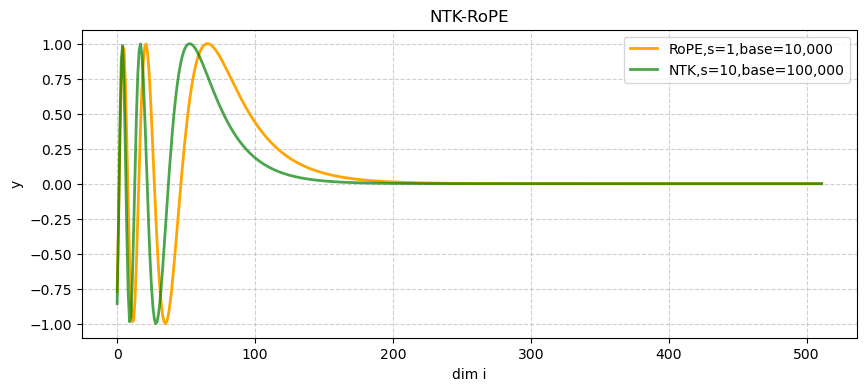

In [169]:
## NTK-RoPE
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 512
m = 16
# n = 32
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
angle_1 = base ** (- 2 * (x - 1) / d)
angle_2 = (base*10) ** (- 2 * (x - 1) / d)

angle_3 = base ** (- 2 * (x - 1) / d)


# 计算正弦值
y1 = torch.sin(m * angle_1)
y2 = torch.sin(m * angle_2)
y3 = torch.sin(m/2 * angle_1)

# 创建图形
plt.figure(figsize=(10, 4))

# 绘制两条曲线
plt.plot(x.tolist(), y1.tolist(), label='RoPE,s=1,base=10,000', color='orange', linewidth=2)
plt.plot(x.tolist(), y2.tolist(), label='NTK,s=10,base=100,000', color='green', linewidth=2, alpha=0.7)
# plt.plot(x.tolist(), y3.tolist(), label='PI,s=2,base=10,000', color='red', linewidth=2, alpha=0.7)

# 添加标题和标签
plt.title('NTK-RoPE')
plt.xlabel('dim i')
plt.ylabel('y')
# plt.xlim(0, 256)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/ntk-rope.svg')
plt.show()

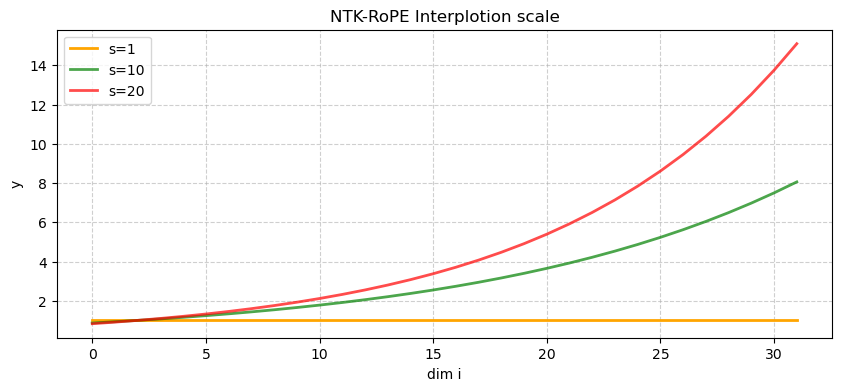

In [170]:
## NTK-RoPE
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 32
m = 16
# n = 32
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
angle_1 = ( 1 ** ( (x - 2) / d))
angle_2 = ((10) ** ( (x - 2) / d))
angle_3 = ((20) ** ( (x - 2) / d))

# 创建图形
plt.figure(figsize=(10, 4))

# 绘制两条曲线
plt.plot(x.tolist(), angle_1.tolist(), label='s=1', color='orange', linewidth=2)
plt.plot(x.tolist(), angle_2.tolist(), label='s=10', color='green', linewidth=2, alpha=0.7)
plt.plot(x.tolist(), angle_3.tolist(), label='s=20', color='red', linewidth=2, alpha=0.7)
# plt.plot(x.tolist(), y3.tolist(), label='PI,s=2,base=10,000', color='red', linewidth=2, alpha=0.7)

# 添加标题和标签
plt.title('NTK-RoPE Interplotion scale')
plt.xlabel('dim i')
plt.ylabel('y')
# plt.xlim(0, 256)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/ntk-rope-scale.svg')
plt.show()

### out-of-bound 分析

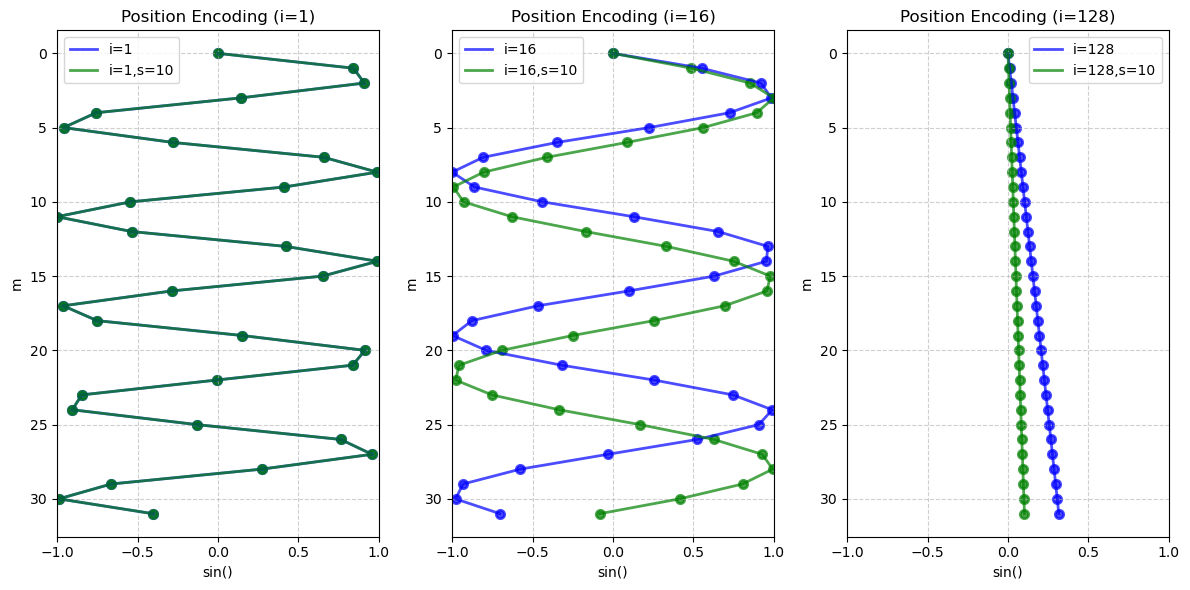

In [171]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_y(i, base, d=512, m=128):
    """
    计算位置编码的正弦值
    
    参数:
    i: 维度索引
    base: 基数
    d: 总维度数 (默认512)
    m: 位置数量 (默认128)
    
    返回:
    y: 正弦值数组
    """
    # 创建横坐标
    x = torch.arange(0, d)
    # 计算角度
    angle = base ** (-2 * (x - 1) / d)
    # 获取特定维度的角度
    a = angle[i]
    # 位置索引
    pos_ids = torch.arange(0, m)
    # 计算正弦值
    y = torch.sin(pos_ids * a)
    
    return y

# 设置参数
d = 512
m = 32
base = 10000

# 创建图形和子图
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
i_values = [1, 16, 128]
colors = ['blue', 'blue', 'blue']

# 为每个i值计算并绘制曲线
for idx, i in enumerate(i_values):
    y = compute_y(i, base, d, m)
    y2 = compute_y(i, base*10, d, m)
    pos_ids = torch.arange(0, m)
    
    axes[idx].scatter(y.tolist(), pos_ids.tolist(), color=colors[idx], linewidth=2, alpha=0.7)
    axes[idx].scatter(y2.tolist(), pos_ids.tolist(), color= 'green', linewidth=2, alpha=0.7)
    axes[idx].plot(y.tolist(), pos_ids.tolist(), label=f'i={i}', color=colors[idx], linewidth=2, alpha=0.7)
    axes[idx].plot(y2.tolist(), pos_ids.tolist(), label=f'i={i},s=10', color= 'green', linewidth=2, alpha=0.7)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('sin()')
    axes[idx].set_ylabel('m')
    axes[idx].set_xlim(-1, 1)
    axes[idx].set_title(f'Position Encoding (i={i})')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('output/bound.svg')
plt.show()

In [173]:
def compute_pi_cos_sin(i, base, scale, d=512, m=128):
    """
    计算位置编码的正弦值
    
    参数:
    i: 维度索引
    base: 基数
    d: 总维度数 (默认512)
    m: 位置数量 (默认128)x
    
    返回:
    y: 正弦值数组
    """
    # 创建横坐标
    x = torch.arange(0, d)
    # 计算角度
    angle = base ** (-2 * (x - 1) / d)
    # 获取特定维度的角度
    a = angle[i]
    # 位置索引
    pos_ids = torch.arange(0, m)
    # 计算正弦值
    y_sin = torch.sin(pos_ids/scale * a)
    y_cos = torch.cos(pos_ids/scale * a)
    
    return y_sin, y_cos

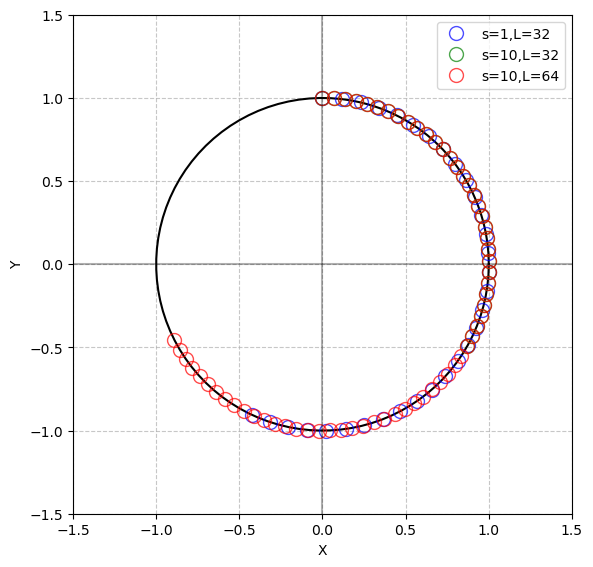

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 设置随机种子以确保结果可重现（可选）
np.random.seed(42)

# 生成单位圆上的点
def generate_unit_circle_points(num_points=100):
    theta = np.linspace(0, 2*np.pi, num_points)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y


# 设置参数
n = 20  # 随机角度数量

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')  # 确保比例相等

# 绘制单位圆
circle_x, circle_y = generate_unit_circle_points()
ax.plot(circle_x, circle_y, 'k-', label='')

# 生成随机射线并绘制
x_ends, y_ends = compute_cos_sin(i = 16, base = 10000,  d=128, m=128)
x_ends_ntk, y_ends_ntk = compute_cos_sin(i = 16, base = 100000,  d=128, m=128)
x_ends_ntk_ex, y_ends_ntk_ex = compute_cos_sin(i = 16, base = 100000,  d=128, m=512)

# 绘制射线和目标点
for i in range(32):
    # 绘制射线
    # ax.plot([0, x_ends[i]], [0, y_ends[i]], 'r-', alpha=0.7, linewidth=1)
    # 绘制目标点
    if i == 0:
        ax.plot(x_ends[i], y_ends[i], 'o', label='s=1,L=32' ,markerfacecolor='none', color= 'blue', markersize=10, alpha=0.7)
        ax.plot(x_ends_ntk[i], y_ends_ntk[i], 'o', label='s=10,L=32', markerfacecolor='none', color= 'green',markersize=10, alpha=0.7)
        # ax.plot(x_ends_ntk_ex[i], y_ends_ntk_ex[i], 'o', label='s=10,L=512', markerfacecolor='none', color= 'red',markersize=10, alpha=0.7)
    else:
        ax.plot(x_ends[i], y_ends[i], 'o' ,markerfacecolor='none', color= 'blue', markersize=10, alpha=0.7)
        ax.plot(x_ends_ntk[i], y_ends_ntk[i], 'o',  markerfacecolor='none', color= 'green',markersize=10, alpha=0.7)
        # ax.plot(x_ends_ntk_ex[i], y_ends_ntk_ex[i], 'o',  markerfacecolor='none', color= 'red',markersize=10, alpha=0.7)
    
    # 添加角度标签（可选）
    # label_angle = angles[i] * 180 / np.pi
    # ax.text(x_ends[i]*1.1, y_ends[i]*1.1, f'{label_angle:.1f}°', 
            # fontsize=8, ha='center', va='center')
for i in range(64):

    if i == 0:
        ax.plot(x_ends_ntk_ex[i], y_ends_ntk_ex[i], 'o', label='s=10,L=64', markerfacecolor='none', color= 'red',markersize=10, alpha=0.7)
    else:
        ax.plot(x_ends_ntk_ex[i], y_ends_ntk_ex[i], 'o',  markerfacecolor='none', color= 'red',markersize=10, alpha=0.7)
    

# 设置图形属性
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('')
ax.grid(True, linestyle='--', alpha=0.7)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax.legend()

# 显示图形
plt.tight_layout()
plt.savefig('output/bound_rope_ntk.svg')
plt.show()

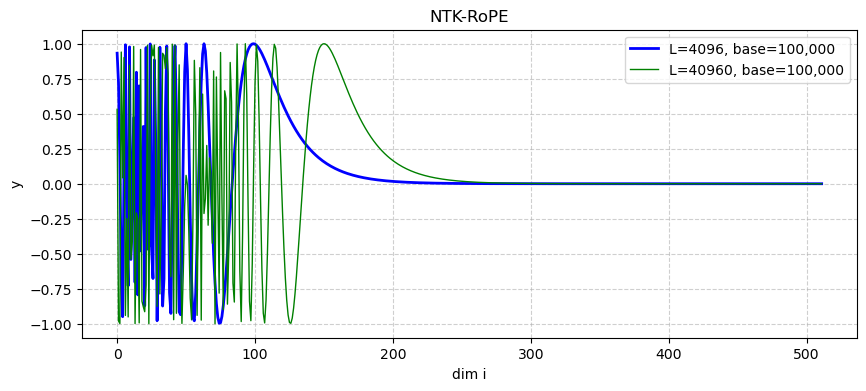

In [176]:
## NTK-RoPE
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 512
m = 128
# n = 32
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
angle_1 = base ** (- 2 * (x - 1) / d)
angle_2 = (base*10) ** (- 2 * (x - 1) / d)



# 计算正弦值
y1 = torch.sin(m * angle_1)
y2 = torch.sin(m*10 * angle_2)
y3 = torch.sin(m * angle_2)

# 创建图形
plt.figure(figsize=(10, 4))

# 绘制两条曲线
# plt.plot(x.tolist(), y1.tolist(), label='RoPE, L=4096, base=10,000', color='blue', linewidth=2, alpha=0.7)
plt.plot(x.tolist(), y3.tolist(), label='L=4096, base=100,000', color='blue', linewidth=2, alpha=1)
plt.plot(x.tolist(), y2.tolist(), label='L=40960, base=100,000', color='green', linewidth=1, alpha=1)

# 添加标题和标签
plt.title('NTK-RoPE')
plt.xlabel('dim i')
plt.ylabel('y')

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/ntk-out-of-bound.svg')
plt.show()

## 波长与旋转圈数

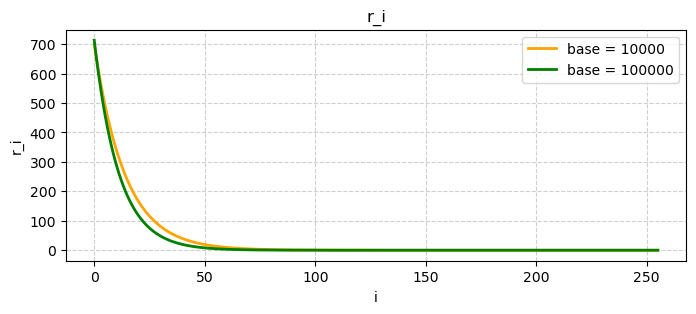

In [177]:
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 256
m = 4096
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
lambda_1 = m / (2 * 3.14159 * base ** ( (2 * (x - 1) ) / d))
lambda_2 = m / (2 * 3.14159 * (base*10) ** (  (2 * (x - 1) )/d))


# # 计算正弦值
# y1 = torch.sin(m * angle)
# y2 = torch.sin(n * angle)

# 创建图形
plt.figure(figsize=(8, 3))

# 绘制两条曲线
plt.plot(x.tolist(), lambda_1.tolist(), label='base = 10000', color='orange', linewidth=2)
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)

# 添加标题和标签
plt.title('r_i')
plt.xlabel('i')
plt.ylabel('r_i')
# plt.xlim(0,10)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/m_curve.svg')
plt.show()

## 分段 YaRN

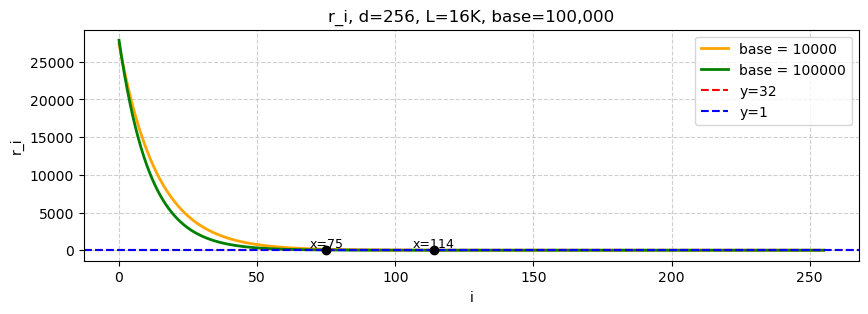

与 y=32 的交点横坐标: 75
与 y=1 的交点横坐标: 114


In [178]:
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 256
m = 160000
base = 10000

# 创建横坐标
x = torch.arange(0, d)
lambda_1 = m / (2 * 3.14159 * base ** ( (2 * (x - 1) ) / d))
lambda_2 = m / (2 * 3.14159 * (base*10) ** (  (2 * (x - 1) )/d))

# 创建图形
plt.figure(figsize=(10, 3))

# 绘制两条曲线
plt.plot(x.tolist(), lambda_1.tolist(), label='base = 10000', color='orange', linewidth=2)
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)

# 添加水平线 y=32 和 y=1
plt.axhline(y=32, color='red', linestyle='--', linewidth=1.5, label='y=32')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5, label='y=1')

# 计算与 lambda_1 曲线的交点
# 找到最接近 y=32 和 y=1 的点
idx_32 = torch.argmin(torch.abs(lambda_2 - 32))
idx_1 = torch.argmin(torch.abs(lambda_2 - 1))

# 获取交点的坐标
x_32 = x[idx_32].item()
y_32 = lambda_2[idx_32].item()
x_1 = x[idx_1].item()
y_1 = lambda_2[idx_1].item()

# 在图上标记交点
plt.scatter([x_32, x_1], [y_32, y_1], color='black', zorder=5)

# 添加交点的横坐标标注
plt.text(x_32, y_32+10, f'x={x_32}', fontsize=9, ha='center', va='bottom')
plt.text(x_1, y_1+10, f'x={x_1}', fontsize=9, ha='center', va='bottom')

# 添加标题和标签
plt.title('r_i, d=256, L=16K, base=100,000')
plt.xlabel('i')
plt.ylabel('r_i')

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/r_i.png')
plt.show()

# 打印交点坐标
print(f"与 y=32 的交点横坐标: {x_32}")
print(f"与 y=1 的交点横坐标: {x_1}")

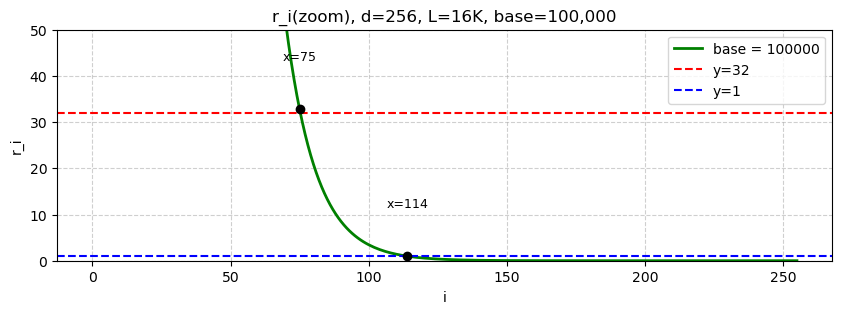

与 y=32 的交点横坐标: 75
与 y=1 的交点横坐标: 114


In [179]:
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 256
m = 160000
base = 10000

# 创建横坐标
x = torch.arange(0, d)
lambda_1 = m / (2 * 3.14159 * base ** ( (2 * (x - 1) ) / d))
lambda_2 = m / (2 * 3.14159 * (base*10) ** (  (2 * (x - 1) )/d))

# 创建图形
plt.figure(figsize=(10, 3))

# 绘制两条曲线
# plt.plot(x.tolist(), lambda_1.tolist(), label='base = 10000', color='orange', linewidth=2)
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)

# 添加水平线 y=32 和 y=1
plt.axhline(y=32, color='red', linestyle='--', linewidth=1.5, label='y=32')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5, label='y=1')

# 计算与 lambda_1 曲线的交点
# 找到最接近 y=32 和 y=1 的点
idx_32 = torch.argmin(torch.abs(lambda_2 - 32))
idx_1 = torch.argmin(torch.abs(lambda_2 - 1))

# 获取交点的坐标
x_32 = x[idx_32].item()
y_32 = lambda_2[idx_32].item()
x_1 = x[idx_1].item()
y_1 = lambda_2[idx_1].item()

# 在图上标记交点
plt.scatter([x_32, x_1], [y_32, y_1], color='black', zorder=5)

# 添加交点的横坐标标注
plt.text(x_32, y_32+10, f'x={x_32}', fontsize=9, ha='center', va='bottom')
plt.text(x_1, y_1+10, f'x={x_1}', fontsize=9, ha='center', va='bottom')

# 添加标题和标签
plt.title('r_i(zoom), d=256, L=16K, base=100,000')
plt.xlabel('i')
plt.ylabel('r_i')
plt.ylim(0,50)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/r_i_zoom.png')
plt.show()

# 打印交点坐标
print(f"与 y=32 的交点横坐标: {x_32}")
print(f"与 y=1 的交点横坐标: {x_1}")

In [180]:
def ntk_part(angle, r, low, high, alpha = 1, beta = 32, scale = 10):
    ntk_angle = angle
    pi_angle = angle / scale
    
    gamma = (r - alpha) / (beta - alpha)
    mix_angle = (1-gamma) * pi_angle + gamma * ntk_angle

    out_angle = ntk_angle.clone()
    out_angle[low:high] = mix_angle[low:high]
    out_angle[high:] = pi_angle[high:]
    return out_angle

## 旋转圈数分析

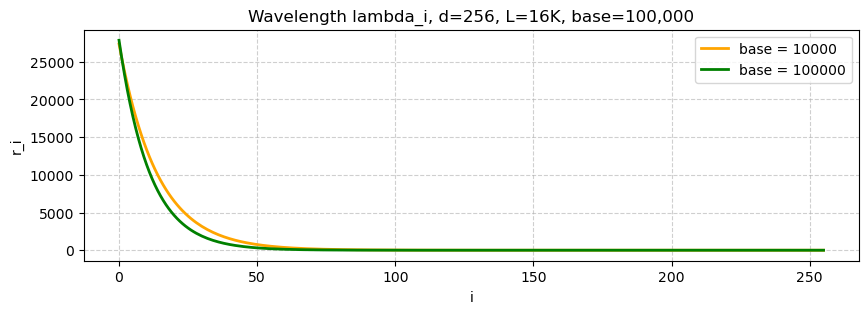

与 y=32 的交点横坐标: 75
与 y=1 的交点横坐标: 114


In [181]:
## Position Encoding - sin()
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 256
m = 160000
base = 10000

# 创建横坐标
x = torch.arange(0, d)
angle =  base ** ( -(2 * (x - 1) ) / d)
r = m / (2 * 3.14159 * base ** ( (2 * (x - 1) ) / d))
low = 75
high = 114





# 创建图形
plt.figure(figsize=(10, 3))

# 绘制两条曲线
plt.plot(x.tolist(), lambda_1.tolist(), label='base = 10000', color='orange', linewidth=2)
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)


# 添加标题和标签
plt.title('Wavelength lambda_i, d=256, L=16K, base=100,000')
plt.xlabel('i')
plt.ylabel('r_i')

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.savefig('output/r_i.svg')
plt.show()

# 打印交点坐标
print(f"与 y=32 的交点横坐标: {x_32}")
print(f"与 y=1 的交点横坐标: {x_1}")

## 动态 Scaling

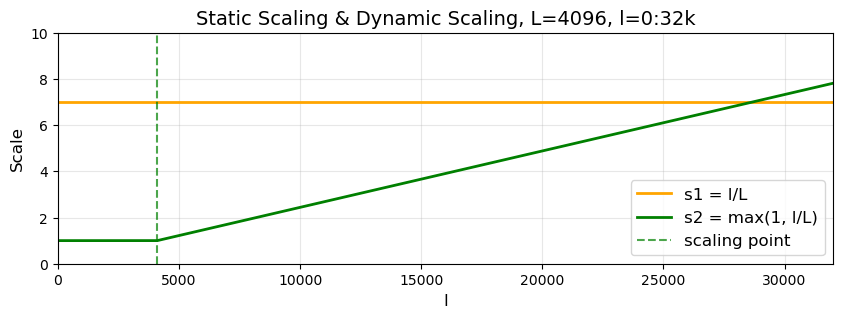

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
L = 4096
x = np.arange(0, 32001, 100)  # 从0到32000，步长为100

# 计算s1和s2
s1 = np.full_like(x, 32000 / L)  # 常数函数
s2 = np.maximum(1, x / L)  # 分段函数

# 创建图形
plt.figure(figsize=(10, 3))

# 绘制s1曲线
plt.plot(x, s1, label=f's1 = l/L', linewidth=2, color='orange')

# 绘制s2曲线
plt.plot(x, s2, label='s2 = max(1, l/L)', linewidth=2, color='green')

# 添加标记点
critical_point = L  # 临界点 x = L
plt.axvline(x=critical_point, color='green', linestyle='--', alpha=0.7, label=f'scaling point')

# 添加网格和图例
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# 设置标题和轴标签
plt.title('Static Scaling & Dynamic Scaling, L=4096, l=0:32k', fontsize=14)
plt.xlabel('l', fontsize=12)
plt.ylabel('Scale', fontsize=12)

# 设置坐标轴范围
plt.xlim(0, 32000)
plt.ylim(0, 10)

# 显示图形
# plt.tight_layout()
plt.savefig('output/dynamic-rope-scale.svg')
plt.show()

## YaRN Scale

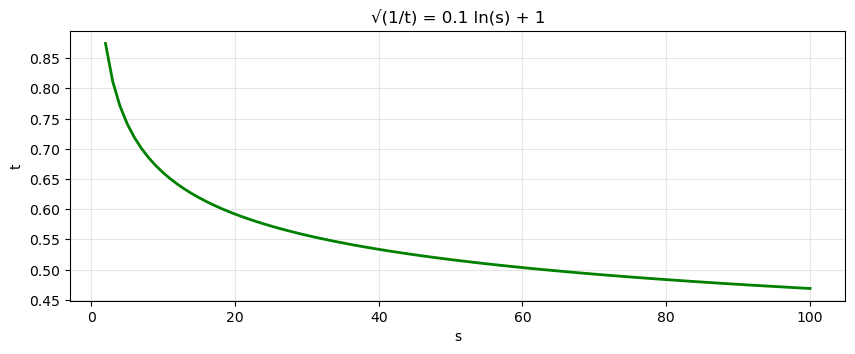

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# 创建 x 值数组，从 1 到 100
x = np.arange(2, 101)

# 计算对应的 t 值
# 注意：当 x=1 时，ln(1)=0，会导致除以零，因此我们需要处理这个特殊情况
t_values = []
for val in x:
    if val == 1:
        # 当 x=1 时，t 趋于无穷大，我们设置为一个很大的数以便可视化
        t_values.append(1000)  # 任意大值，表示无穷大
    else:
        t_values.append(1 / (0.1 * np.log(val)+1)**2)

# 创建图形
plt.figure(figsize=(10, 3.5))
plt.plot(x, t_values, 'g-', linewidth=2)
plt.xlabel('s')
plt.ylabel('t')
plt.title('√(1/t) = 0.1 ln(s) + 1')
plt.grid(True, alpha=0.3)

# 设置 y 轴范围，排除无穷大值以便更好地观察趋势
# plt.ylim(0, 100)
plt.savefig('output/yarn-rescale.svg')
plt.show()